# Grab the vertices of the glacier terminus boxes in pixel coordinates

### Jukes Liu

The vertices of the glacier terminus box will be used to calculate a midpoint of the left edge of the terminus box, which will be our reference point for calculating terminus position.

### Import packages, set basepath, grab BoxIDs for terminus boxes

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
os.chdir('/home/jukes/automated-glacier-terminus')
from automated_terminus_functions import midpoint

basepath = '/home/jukes/Documents/Sample_glaciers/'

In [4]:
#grab the BoxIDs
pathrows_df = pd.read_csv(basepath+'LS_pathrows_multiple.csv', sep=',', usecols =[0,1,2], dtype=str)
pathrows_df = pathrows_df.set_index('BoxID')
# pathrows_df = pathrows_df.drop('215')
pathrows_df
BoxIDs = set(list(pathrows_df.index))
print(BoxIDs)

{'277', '004', '531', '001', '259', '002', '033', '120', '174', '235'}


### Read in terminus box rasters and perform a visual check

In [5]:
#create dictionary to store each terminus box ndarray by BoxID
termboxes = {}

#read in the terminus box rasters
for BoxID in BoxIDs:
    #load in the raster
#     boxpath = basepath+"Box"+BoxID+"/rotated_images/final/crop_Box"+BoxID+"_raster_cut.pgm"
    boxpath = "/media/jukes/jukes1/LS8aws/Box"+BoxID+"/rotated/R_Box"+BoxID+"_raster_cut.pgm"
    #read the raster into an ndarray
    termbox = mpimg.imread(boxpath)
    #add the ndarray into a dictionary with the BoxID as the key
    termboxes.update( {BoxID: termbox} )

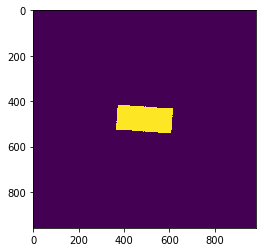

In [6]:
#visualize each terminus box rasters by BoxID
termplot = plt.imshow(termboxes['033'])
plt.show()

### Find x,y coordinates of box vertices and midpoints of left and right edges to get the centerline

    1) Left side
        1A) Top Left (lowest x*y)
        1B) Bottom Left (highest y/x)
        1C) Midpoint of 1A and 1B:
$\dfrac{x_{1}+x_{2}}{2}$ , $\dfrac{y_{1}+y_{2}}{2}$

    2) Right side
        2A) Top Right (highest y/x)
        2B) Bottom Right (highest x*y)
        2C) Midpoint of 2A and 2B.
        
    3) Centerline equation

Calculate the equation for the centerline (slope between the two midpoints). Just need to calculate slope: $m =\dfrac{y_{2}-y_{1}}{x_{2}-x_{1}}$

and solve for the intercept using one of the midpoint coordinate pairs: $b = y - mx$

$y = mx + b$

In [7]:
#create dictionary to store the all coordinates of the box rasters
boxes_xcoords = {}; boxes_ycoords = {}

#create dictionaries for the box vertices
topleft_coords = {}; bottomleft_coords = {}; topright_coords = {} ;bottomright_coords = {}

#create lists to store the left midpoints (1C) and right midpoints (2C)
midpoints_x = []; midpoints_y = []
midpoints_r_x = []; midpoints_r_y = []
mids_l025_x = []; mids_l025_y = []
mids_r025_x = []; mids_r025_y = []
mids_l075_x = []; mids_l075_y = []
mids_r075_x = []; mids_r075_y = []

#create lists to store the slopes and intercepts of the centerline equations
slope_50 = []; intercept_50 = []; slope_25 = []; intercept_25 = []; slope_75 = []; intercept_75 = []; boxes = []

#for all the box rasters
for BoxID in BoxIDs:
    #Read in the raster of the BoxID of interest
    BOI = termboxes[BoxID]
    
    #find the coordinates of where the pixel value is nonzero (where the box exists)
    yindices, xindices = np.where(BOI > 0)

    #add box coordinates to the dictionary
    boxes_ycoords.update( {BoxID: yindices}) ;boxes_xcoords.update( {BoxID: xindices})
    
    
    #1A) FIND THE TOP LEFT COORDINATES (lowest x*y)
    xy = xindices*yindices
    #Find the lowest xy value
    min_xy = np.min(xy)
    #Find the x and y pair corresponding to that xy using the index
    min_xy_i = np.where(xy == min_xy)[0][0]
    topleft = [xindices[min_xy_i], yindices[min_xy_i]]
#     print("Top left", topleft)
    #Add to dictionary of topleft coordinates
    topleft_coords.update(  {BoxID: topleft}  )
    
    #2B) FIND THE BOTTOM RIGHT COORDINATES (highest x*y)
    max_xy = np.max(xy)
    max_xy_i = np.where(xy == max_xy)[0][0]
    bottomright = [xindices[max_xy_i], yindices[max_xy_i]]
    bottomright_coords.update( {BoxID: bottomright})

    #1B) FIND THE BOTTOM LEFT COORDINATE(highest y/x)
    y_x = yindices/xindices
    #Find the highest y/x value
    max_y_x = np.max(y_x)
    #Find the x and y pair corresponding to that y/x using the index
    max_y_x_i = np.where(y_x == max_y_x)[0][0]
    bottomleft = [xindices[max_y_x_i], yindices[max_y_x_i]]
#     print("Bottom left", bottomleft)
    #Add to dictionary of bottomleft coordinates
    bottomleft_coords.update( {BoxID: bottomleft}  )
    
    #2A) FIND THE TOP RIGHT COORDINATES (highest x/y)
    x_y = xindices/yindices
    #find highest x/y value:
    max_x_y = np.max(x_y)
    #Find the x, y pair correpsonding to the maximum x/y using the index
    max_x_y_i = np.where(x_y == max_x_y)[0][0]
    topright = [xindices[max_x_y_i], yindices[max_x_y_i]]
    topright_coords.update( {BoxID: topright} )
    
    #1C and 2C) CALCULATE THE MIDPOINTS USING MIDPOINT FUNCTION
    #Left
    midpoint_x, midpoint_y = midpoint(topleft[0], topleft[1], bottomleft[0], bottomleft[1])
    #Right
    midpoint_r_x, midpoint_r_y = midpoint(topright[0], topright[1], bottomright[0], bottomright[1])
    
#     #Add x and y coordinates to dictionaries
#     midpoints_x.update( {BoxID: midpoint_x}  )
#     midpoints_y.update( {BoxID: midpoint_y}  )
#     midpoints_r_x.update( {BoxID: midpoint_r_x})
#     midpoints_r_y.update( {BoxID: midpoint_r_y})
    
    #GRAB 1/4th and 3/4ths lines (midpoints)
    mid_l025_x, mid_l025_y = midpoint(topleft[0], topleft[1], midpoint_x, midpoint_y)
    mid_r025_x, mid_r025_y = midpoint(topright[0], topright[1], midpoint_r_x, midpoint_r_y)
    
    mid_l075_x, mid_l075_y = midpoint(bottomleft[0], bottomleft[1], midpoint_x, midpoint_y)
    mid_r075_x, mid_r075_y = midpoint(bottomright[0], bottomright[1], midpoint_r_x, midpoint_r_y)
    
    #3) CALCULATE CENTERLINE EQUATIONS
    #1/2
    #slope = (y2-y1)/(x2-x1)
    m = (midpoint_r_y - midpoint_y)/(midpoint_r_x - midpoint_x)
    #y-intercept = y1 - m*x1
    b = midpoint_y - (m*midpoint_x)
#     print("y =", m, "x +", b)

    #1/4
    m025 = (mid_r025_y-mid_l025_y)/(mid_r025_x-mid_l025_x); b025 = mid_l025_y - (m*mid_l025_x)
    
    #3/4
    m075 = (mid_r075_y-mid_l075_y)/(mid_r075_x-mid_l075_x); b075 = mid_l075_y - (m*mid_l075_x)
    
    #append BoxIDs, slopes, intercepts, midpoints, and centerlines to lists
    boxes.append(BoxID); midpoints_x.append(midpoint_x); midpoints_y.append(midpoint_y)
    midpoints_r_x.append(midpoint_r_x); midpoints_r_y.append(midpoint_r_y)
    
    mids_l025_x.append(mid_l025_x); mids_l025_y.append(mid_l025_y); mids_r025_x.append(mid_r025_x); mids_r025_y.append(mid_r025_y)
    
    mids_l075_x.append(mid_l075_x) ;mids_l075_y.append(mid_l075_y) ;mids_r075_x.append(mid_r075_x) ;mids_r075_y.append(mid_r075_y)
    
    slope_50.append(m); intercept_50.append(b)
    slope_25.append(m025) ;intercept_25.append(b025)
    slope_75.append(m075); intercept_75.append(b075)
    
#create a dataframe
total_df = pd.DataFrame(list(zip(boxes, midpoints_x, midpoints_y, midpoints_r_x, midpoints_r_y, slope_50, 
                                 intercept_50, mids_l025_x, mids_l025_y, mids_r025_x, mids_r025_y, slope_25, 
                                 intercept_25, mids_l075_x, mids_l075_y, mids_r075_x, mids_r075_y, slope_75, 
                                intercept_75)), 
                        columns=['BoxID', 'lmid50_x', 'lmid50_y', 'rmid50_x','rmid50_y', 'm50', 'b50',
                                 'lmid25_x', 'lmid25_y','rmid25_x','rmid25_y', 'm25', 'b25',
                                 'lmid75_x', 'lmid75_y', 'rmid75_x','rmid75_y', 'm75', 'b75'])

total_df = total_df.drop_duplicates().set_index('BoxID')
total_df

,lmid50_x,lmid50_y,rmid50_x,rmid50_y,m50,b50,lmid25_x,lmid25_y,rmid25_x,rmid25_y,m25,b25,lmid75_x,lmid75_y,rmid75_x,rmid75_y,m75,b75
BoxID,,,,,,,,,,,,,,,,,,
277,151.5,203.0,244.0,208.5,0.059459,193.991892,152.25,189.50,245.00,194.75,0.056604,180.447297,150.75,216.50,243.00,222.25,0.062331,207.536486
004,499.0,647.0,789.0,571.5,-0.260345,776.912069,486.00,597.00,776.50,521.25,-0.260757,723.527586,512.00,697.00,801.50,621.75,-0.259931,830.296552
531,184.5,261.5,268.0,219.5,-0.502994,354.302395,170.75,234.25,254.50,192.25,-0.501493,320.136228,198.25,288.75,281.50,246.75,-0.504505,388.468563
001,116.0,157.0,189.5,163.0,0.081633,147.530612,117.00,147.50,189.75,153.00,0.075601,137.948980,115.00,166.50,189.25,173.00,0.087542,157.112245
259,235.0,490.0,561.0,526.5,0.111963,463.688650,237.50,468.50,563.50,505.25,0.112730,441.908742,232.50,511.50,558.50,547.75,0.111196,485.468558
002,468.5,592.5,751.0,568.0,-0.086726,633.130973,465.25,554.25,748.00,530.00,-0.085765,594.599115,471.75,630.75,754.00,606.00,-0.087688,671.662832
033,369.5,471.5,612.0,487.5,0.065979,447.120619,371.25,444.25,614.00,460.25,0.065911,419.755155,367.75,498.75,610.00,514.75,0.066047,474.486082
120,111.0,147.5,182.5,153.5,0.083916,138.185315,112.50,132.25,183.75,137.75,0.077193,122.809441,109.50,162.75,181.25,169.25,0.090592,153.561189
174,259.5,335.0,395.5,314.0,-0.154412,375.069853,255.25,307.50,391.25,285.50,-0.161765,346.913603,263.75,362.50,399.75,342.50,-0.147059,403.226103


### Visual check of the vertices, midpoints, and centerlines by plotting over terminus box:

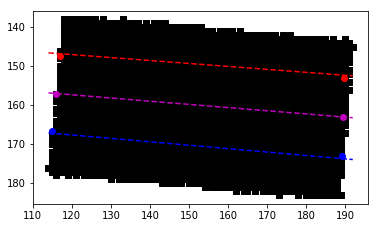

In [34]:
#Choose which glacier BoxID to check:
BOI_ID = '001'

#plot the raster pixels in black
plt.scatter(boxes_xcoords[BOI_ID], boxes_ycoords[BOI_ID], c='k',marker='s')

#plot the vertices
# plt.scatter(topleft_coords[BOI_ID][0], topleft_coords[BOI_ID][1], c='y')
# plt.scatter(bottomleft_coords[BOI_ID][0], bottomleft_coords[BOI_ID][1], c='y')
# plt.scatter(topright_coords[BOI_ID][0], topright_coords[BOI_ID][1], c='y')
# plt.scatter(bottomright_coords[BOI_ID][0], bottomright_coords[BOI_ID][1], c='y')

#plot midpoints
plt.scatter(total_df.at[BOI_ID,'lmid50_x'], total_df.at[BOI_ID,'lmid50_y'], c='m')
plt.scatter(total_df.at[BOI_ID, 'rmid50_x'], total_df.at[BOI_ID, 'rmid50_y'], c='m')
plt.scatter(total_df.at[BOI_ID,'lmid25_x'], total_df.at[BOI_ID,'lmid25_y'], c='r')
plt.scatter(total_df.at[BOI_ID, 'rmid25_x'], total_df.at[BOI_ID, 'rmid25_y'], c='r')
plt.scatter(total_df.at[BOI_ID,'lmid75_x'], total_df.at[BOI_ID,'lmid75_y'], c='b')
plt.scatter(total_df.at[BOI_ID, 'rmid75_x'], total_df.at[BOI_ID, 'rmid75_y'], c='b')

#plot the centerlines in cyan
x=np.linspace(np.min(boxes_xcoords[BOI_ID]), np.max(boxes_xcoords[BOI_ID]))
y50=(total_df.at[BOI_ID, 'm50'])*x + (total_df.at[BOI_ID, 'b50'])
y25=(total_df.at[BOI_ID, 'm25'])*x + (total_df.at[BOI_ID, 'b25'])
y75=(total_df.at[BOI_ID, 'm75'])*x + (total_df.at[BOI_ID, 'b75'])
plt.plot(x, y50, '--m', x, y25, '--r', x, y75, '--b')
         
plt.gca().invert_yaxis()
plt.axis('scaled')
plt.show()

### Drop right midpoint columns and dataframe to csv

In [35]:
#drop the right midpoints
# total_df = total_df.drop(['rmid50_x', 'rmid50_y', 'rmid25_x', 'rmid25_y', 'rmid75_x', 'rmid75_y'], axis=1)
total_df = total_df.drop(['rmid50_y', 'rmid25_y', 'rmid75_y'], axis=1)
total_df

,lmid50_x,lmid50_y,rmid50_x,m50,b50,lmid25_x,lmid25_y,rmid25_x,m25,b25,lmid75_x,lmid75_y,rmid75_x,m75,b75
BoxID,,,,,,,,,,,,,,,
259,235.0,490.0,561.0,0.111963,463.688650,237.50,468.50,563.50,0.112730,441.908742,232.50,511.50,558.50,0.111196,485.468558
120,111.0,147.5,182.5,0.083916,138.185315,112.50,132.25,183.75,0.077193,122.809441,109.50,162.75,181.25,0.090592,153.561189
277,151.5,203.0,244.0,0.059459,193.991892,152.25,189.50,245.00,0.056604,180.447297,150.75,216.50,243.00,0.062331,207.536486
531,184.5,261.5,268.0,-0.502994,354.302395,170.75,234.25,254.50,-0.501493,320.136228,198.25,288.75,281.50,-0.504505,388.468563
235,178.0,226.5,288.0,-0.136364,250.772727,176.00,212.25,286.00,-0.136364,236.250000,180.00,240.75,290.00,-0.136364,265.295455
174,259.5,335.0,395.5,-0.154412,375.069853,255.25,307.50,391.25,-0.161765,346.913603,263.75,362.50,399.75,-0.147059,403.226103
001,116.0,157.0,189.5,0.081633,147.530612,117.00,147.50,189.75,0.075601,137.948980,115.00,166.50,189.25,0.087542,157.112245
033,369.5,471.5,612.0,0.065979,447.120619,371.25,444.25,614.00,0.065911,419.755155,367.75,498.75,610.00,0.066047,474.486082
004,499.0,647.0,789.0,-0.260345,776.912069,486.00,597.00,776.50,-0.260757,723.527586,512.00,697.00,801.50,-0.259931,830.296552


#### Export to Boxes_coords_pathrows.csv

In [36]:
total_df.to_csv(path_or_buf = basepath+'Boxes_coords_pathrows.csv', sep=',')